# Analysis of DNA-MERFISH for CTP11

by Pu Zheng

2022.06.15

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_5\20220419-P_brain_CTP11-13_from_0415storm65'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220415-P_brain_M1_noclear_storm65'

save_folder = r'\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65'

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

37756


## 0.1 Folders

In [2]:
save_folder = r'\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

217 fovs detected
Use segmentation_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Segmentation
Use cand_spot_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\CandSpots
Use decoder_folder: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder


In [3]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Decoding of DNA-MERFISH

In [4]:
# load two codebooks
import pandas as pd

ctp11_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv', header=0)
ctp13_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-super-enhancers-1000_codebook.csv', header=0)
ctp13_codebook

,name,id,NDB_376,NDB_578,NDB_400,NDB_533,NDB_568,NDB_464,NDB_466,NDB_431,...,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604,chr,chr_order
0,1:9600471-9656458,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1:9749317-9845402,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
2,1:20888605-20953251,3,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,2
3,1:21475446-21564433,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3
4,1:21674557-21793163,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,X:101910335-102015609,987,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,X,2
964,X:136772307-136851006,988,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,3
965,X:140481839-140547985,989,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,4
966,X:167122110-167191320,990,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,X,5


## Load bit_2_name

In [5]:
readout_df_gn = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_combo_readouts.csv')
readout_df_se = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-13_brain-super-enhancers\Summary_tables\CTP13-mouse-SE_combo_readouts.csv')

# merge
readout_df_se['Bit']+=100
readout_df = pd.concat([readout_df_gn, readout_df_se])
readout_df

,Bit,ReadoutName
0,1,NDB_784
1,2,NDB_755
2,3,NDB_826
3,4,NDB_713
4,5,NDB_865
...,...,...
90,191,NDB_592
91,192,NDB_368
92,193,NDB_436
93,194,NDB_629


## 3.3 prepare kwargs to decode CTP11

In [6]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp11_data_type = 'combo'
ctp11_decode_args = []
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp11_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp11_decode_args.append(
            ('CTP11', _cell_spots_df, ctp11_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    break
print(len(ctp11_decode_args))

- Preparing decoding args for fov: 0
102
Wall time: 3.4 s


<IPython.core.display.Javascript object>


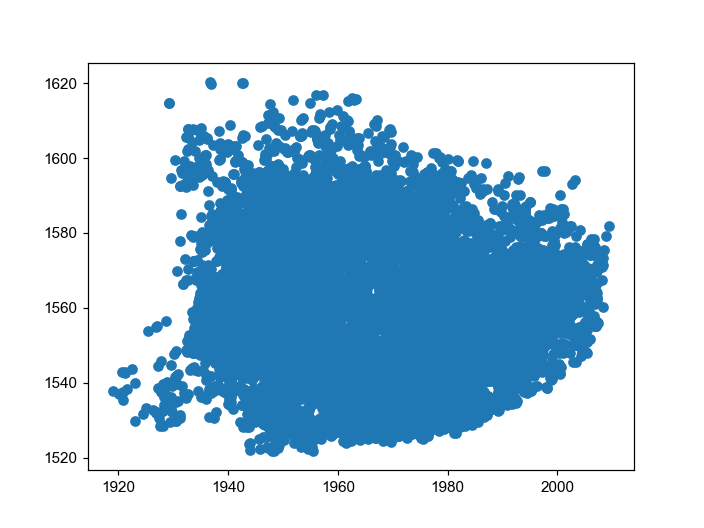

In [15]:
plt.figure()
plt.scatter(ctp11_decode_args[61][1]['x'], ctp11_decode_args[61][1]['y'])

In [10]:
ctp11_decode_args[1][1]

,fov_id,cell_id,height,z,x,y,background,sigma_z,sigma_x,sigma_y,sin_t,sin_p,eps,bit,channel,uid,pixel_z,pixel_x,pixel_y
1992,0,2,3336.18240,4.686987,8.034546,341.59753,1.408116e+02,1.760655,1.593115,1.517241,1.000000,-1.000000,265.913570,1,750,b'148041530916932573267031500028613553697',250,108,108
2810,0,2,2966.73950,8.844625,15.965576,398.68073,4.615628e+01,1.246253,1.352783,2.418395,0.303508,-0.675593,130.329740,1,750,b'148041530916932573267031500028613553697',250,108,108
3146,0,2,2614.68260,5.484096,13.953003,395.54584,3.327743e+01,1.240618,1.524777,2.649163,0.414927,-0.642379,113.553570,1,750,b'148041530916932573267031500028613553697',250,108,108
3636,0,2,1587.65050,15.182641,11.923584,399.99515,9.440660e+01,1.505474,4.000000,1.686198,-0.175896,1.000000,205.903140,1,750,b'148041530916932573267031500028613553697',250,108,108
4934,0,2,1623.57540,13.342625,7.540283,376.31033,7.732995e-13,2.268824,2.776677,2.442345,1.000000,1.000000,175.713100,1,750,b'148041530916932573267031500028613553697',250,108,108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1301562,0,2,1279.01090,14.328548,20.666260,396.50170,1.351772e+03,1.588630,1.882522,1.051972,-0.699551,0.988482,100.239075,195,561,b'148041530916932573267031500028613553697',250,108,108
1301777,0,2,1149.94860,5.175535,16.771484,354.60153,1.305446e+03,1.653471,1.694364,1.308339,-0.544105,-1.000000,121.826065,195,561,b'148041530916932573267031500028613553697',250,108,108
1303139,0,2,908.10850,11.010576,17.872314,390.04257,1.319813e+03,1.824309,1.432141,1.343338,1.000000,-1.000000,103.423800,195,561,b'148041530916932573267031500028613553697',250,108,108
1303811,0,2,777.69415,24.551664,28.075195,359.35904,1.198124e+03,1.627673,1.308715,1.892652,0.268635,1.000000,69.427480,195,561,b'148041530916932573267031500028613553697',250,108,108


## 3.4 prepare kwargs to decode CTP13

In [24]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotDecoder

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

pair_search_radius = 300
pair_search_eps = 0.25
ctp13_data_type = 'combo'
ctp13_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp13_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        # prepare args
        ctp13_decode_args.append(
            ('CTP13', _cell_spots_df, ctp13_codebook, readout_df, _decoder_filename,
             pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
        )
    
print(len(ctp13_decode_args))

- Preparing decoding args for fov: 0
- Preparing decoding args for fov: 1
- Preparing decoding args for fov: 2
- Preparing decoding args for fov: 3
- Preparing decoding args for fov: 4
- Preparing decoding args for fov: 5
- Preparing decoding args for fov: 6
- Preparing decoding args for fov: 7
- Preparing decoding args for fov: 8
- Preparing decoding args for fov: 9
- Preparing decoding args for fov: 10
- Preparing decoding args for fov: 11
- Preparing decoding args for fov: 12
- Preparing decoding args for fov: 13
- Preparing decoding args for fov: 14
- Preparing decoding args for fov: 15
- Preparing decoding args for fov: 16
- Preparing decoding args for fov: 17
- Preparing decoding args for fov: 18
- Preparing decoding args for fov: 19
- Preparing decoding args for fov: 20
- Preparing decoding args for fov: 21
- Preparing decoding args for fov: 22
- Preparing decoding args for fov: 23
- Preparing decoding args for fov: 24
- Preparing decoding args for fov: 25
- Preparing decoding a

- Preparing decoding args for fov: 213
- Preparing decoding args for fov: 214
- Preparing decoding args for fov: 215
- Preparing decoding args for fov: 216
24687
Wall time: 15min 54s


## 3.5 prepare kwargs to map sequential CTP12

In [9]:
ctp12_codebook = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_sequential-codebook.csv', header=0)
ctp12_codebook

,name,id,chr,Stv_91,Stv_32,Stv_92,Stv_33,Stv_94,Stv_35,Stv_95,...,Stv_106,Stv_45,Stv_107,Stv_46,Stv_109,Stv_48,Stv_118,Stv_50,Stv_119,Stv_53
0,5:31098237-31118237,Slc30a3,5,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7:45153949-45173949,Slc17a7,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2:158600767-158620767,Slc32a1,2,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2:70543072-70563072,Gad1,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5:30451932-30471932,Otof,5,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4:124976430-124996430,Rspo1,4,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,15:78196400-78216400,Pvalb,15,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,16:23880958-23900958,Sst,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10:5629218-5649218,Vip,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,14:34364789-34384789,Sncg,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
ctp12_readout_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-12_mop_markers\Summary_tables\CTP12-TSS_unique_readouts.csv', header=0)
ctp12_readout_df

,Bit,ReadoutName
0,1,Stv_91
1,2,Stv_32
2,3,Stv_92
3,4,Stv_33
4,5,Stv_94
5,6,Stv_35
6,7,Stv_95
7,8,Stv_36
8,9,Stv_99
9,10,Stv_37


In [11]:
%%time
from tqdm import tqdm
from ImageAnalysis3.classes import new_decoder
reload(ia.classes.new_decoder)
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper

overwrite_decoder = False
verbose_decoder = True
return_decoder = False

ctp12_data_type = 'unique'
ctp12_decode_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    print(f"- Preparing decoding args for fov: {_fov_id}")
    # load candidate spots for the fov
    cand_spot_filename = os.path.join(cand_spot_folder, ctp12_data_type,
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(cand_spot_filename):
        _fov_spots_df = pd.read_csv(cand_spot_filename)
    else:
        continue # skip if fov doesn't exist
        
    for _cell_id in np.unique(_fov_spots_df['cell_id']):
        # get decoder filename
        _decoder_filename = os.path.join(decoder_folder, f"Decoded_fov-{_fov_id}_cell-{_cell_id}.hdf5")
        # get cell_df
        _cell_spots_df =_fov_spots_df[_fov_spots_df['cell_id']==_cell_id]
        if len(_cell_spots_df) > 0:
            # prepare args
            ctp12_decode_args.append(
                ('CTP12tss', _cell_spots_df, ctp12_codebook, ctp12_readout_df, _decoder_filename,
                 pair_search_radius, pair_search_eps, overwrite_decoder, verbose_decoder, return_decoder)
            )
    break
print(len(ctp12_decode_args))

- Preparing decoding args for fov: 0
101
Wall time: 71.6 ms


## Test decoding for one cell

In [12]:
%matplotlib inline
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
sel_cell = 10

# conbinatorial
batch_process_SpotDecoder(*ctp11_decode_args[sel_cell])
batch_process_SpotDecoder(*ctp13_decode_args[sel_cell])
# sequential
batch_process_SpotMapper(*ctp12_decode_args[sel_cell])

- Load decoder from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- savefile:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5 not exist, skip
- Matching 194 bits to (988, 103) codebook
-- 99 bits matched
- Process (988, 102) codebook into valid pairs
-- 2964 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook


E:\Users\puzheng\Documents\ImageAnalysis3\classes\new_decoder.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.bit_codebook[_matched_bit[0]] = self.codebook[_col].copy()


-- 7309 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|████████████████████████████████████████████████████████████████████████████| 7309/7309 [00:01<00:00, 6385.88it/s]


-- 759 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████| 7309/7309 [00:00<00:00, 102974.64it/s]


-- 845 pairs selected
-- in total 1604 spot_groups detected
- Save decoder of CTP11 into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups


E:\Users\puzheng\anaconda3\envs\ia3_postanalysis\lib\site-packages\pandas\core\generic.py:2703: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['uid', 'homolog', 'channel_0', 'channel_1', 'channel_2', 'region_name',
       'start', 'end', 'chr'],
      dtype='object')]

  pytables.to_hdf(


- Save spot_stats iamage to file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11_CTP11_stats.png
- Load decoder from file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- savefile:\\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5 doesn't have information for CTP13, skip
- Matching 194 bits to (968, 99) codebook
-- 95 bits matched
- Process (968, 98) codebook into valid pairs
-- 2904 valid pairs detected.
- Searching for spot-pairs within 300nm.
-- find candidate pairs by KDTree
-- filter candidate pairs by codebook
-- 8060 pairs selected.
- Select spot_groups from candidate pairs with radius:300, max_usage=1
-- calculate scores for candSpotPairs


100%|████████████████████████████████████████████████████████████████████████████| 8060/8060 [00:01<00:00, 6446.74it/s]


-- 789 full tuples selected


100%|██████████████████████████████████████████████████████████████████████████| 8060/8060 [00:00<00:00, 124003.98it/s]


-- 874 pairs selected
-- in total 1663 spot_groups detected
- Save decoder of CTP13 into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- existing info: [] and []
-- save bits
-- save search_radius to attrs
-- save search_eps to attrs
-- save readoutDf
-- save codebook
-- save candSpots
-- save spotGroups
- Save spot_stats iamage to file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11_CTP13_stats.png
- Matching 28 bits to (28, 31) codebook
-- 28 bits matched
- Save decoder of CTP12tss into file: \\mendel\Mendel_SSD4\Pu_Temp\20220419-CTP11-13_from_0415storm65\Decoder\Decoded_fov-0_cell-11.hdf5
-- existing info: []
-- save bits
-- save readoutDf
-- save codebook
-- save candSpots


## load decoded results

In [13]:
sel_col = ['region_name', 'chr','start','end','center_intensity', 'center_z', 'center_x', 'center_y']

ctp11_decoded_df = pd.read_hdf(ctp11_decode_args[sel_cell][4], 'CTP11/spotGroups')[sel_col]
ctp13_decoded_df = pd.read_hdf(ctp13_decode_args[sel_cell][4], 'CTP13/spotGroups')[sel_col]

ctp12_decoded_df = pd.read_hdf(ctp12_decode_args[sel_cell][4], 'CTP12tss/candSpots')[sel_col]

## 3D rendering of decoded spots

In [14]:
decoded_figure_folder = os.path.join(decoder_folder, 'Decoded_3D')
if not os.path.exists(decoded_figure_folder):
    os.makedirs(decoded_figure_folder)

In [15]:
from matplotlib import animation
plot_animation = True
angle = 3

from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
figure_width = _double_col_width
figure_dpi=100
background_color = [0,0,0]
marker_size = 8
marker_alpha = 1

depthshade=False

<IPython.core.display.Javascript object>


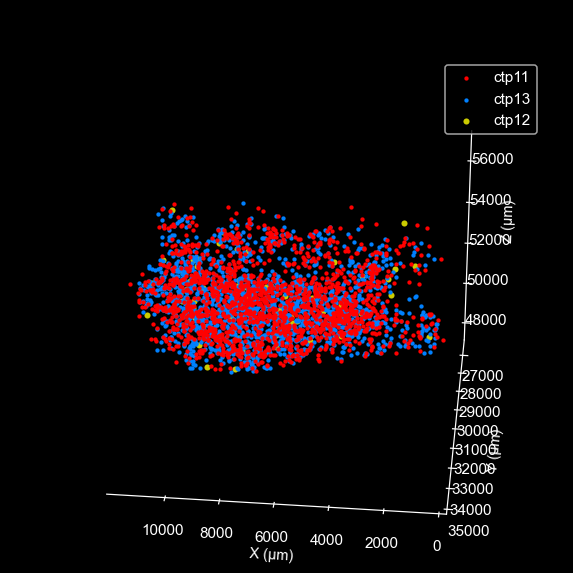

In [16]:
%matplotlib notebook
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')
plt.style.use('dark_background')
fig = plt.figure(figsize=(figure_width, figure_width), dpi=figure_dpi)
ax3d = fig.add_subplot(111, projection='3d')
ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.9)
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

#"ctp11"
_sc = ax3d.scatter(ctp11_decoded_df['center_z'], ctp11_decoded_df['center_x'], ctp11_decoded_df['center_y'], 
                   color=[1,0,0,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp11')
#"ctp13"
_sc = ax3d.scatter(ctp13_decoded_df['center_z'], ctp13_decoded_df['center_x'], ctp13_decoded_df['center_y'], 
                   color=[0,0.5,1,1], 
                   s=marker_size, depthshade=depthshade, 
                   alpha=marker_alpha,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp13')
#"ctp12"
_sc = ax3d.scatter(ctp12_decoded_df['center_z'], ctp12_decoded_df['center_x'], ctp12_decoded_df['center_y'], 
                   color=[0.8,0.8,0,1], 
                   s=marker_size*2, depthshade=depthshade, 
                   alpha=1,
                   #edgecolors=_edge_colors, 
                   linewidth=0, label='ctp12')
ax3d.legend()

# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size+2, labelpad=1)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size+2, labelpad=1)
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(decoded_figure_folder, f"3D_{os.path.basename(ctp11_decode_args[sel_cell][4]).replace('.hdf5','.gif')}"), 
             writer=animation.PillowWriter(fps=30), )
fig.show()

# 4. Process All

In [17]:
from ImageAnalysis3.classes.new_decoder import batch_process_SpotMapper, batch_process_SpotDecoder
import multiprocessing as mp

## 4.1 CTP11

In [23]:
%%time
print(len(ctp11_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp11_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

24687


ValueError: need at least one array to concatenate

## 4.2 CTP13

In [ ]:
%%time
print(len(ctp13_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotDecoder, ctp13_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

24687


## 4.3 CTP12 TSS sequential

In [21]:
%%time
print(len(ctp12_decode_args))
with mp.Pool(32) as decode_pool:
    decode_results = decode_pool.starmap(batch_process_SpotMapper, ctp12_decode_args, chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

101
Wall time: 10.9 s
